In [1]:
from scipy.spatial.distance import cosine
import numpy as np
import pandas as pd
import seaborn as sns
import h5py
import umap
import networkx as nx
from node2vec import Node2Vec
from TDAembedding import TDAembedding
from sbm_utils import generate_clusters
import matplotlib.pyplot as plt
%matplotlib inline

# Comparing embedding node2vec and TDA with UMAP

## Strong blocks

In [2]:
fname = "wAdj_0.3_0.4_0.3_2_2.mat"
with h5py.File(fname,'r') as f:
    wAdj = np.array(f[list(f.keys())[0]])
pi_vector = [float(str.split(fname,'_')[el]) for el in range(1,4)]  
target = generate_clusters(wAdj.shape[0], pi_vector).astype('int')

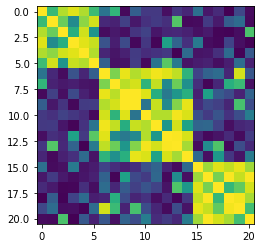

In [3]:
plt.imshow(wAdj)

### Node2vec Embedding

In [4]:
graph = nx.from_numpy_matrix(wAdj)
node2vec = Node2Vec(graph, dimensions=25, walk_length=15, p=0.5,q=1, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 645.26it/s]


In [5]:
nodes = [str(node) for node in range(wAdj.shape[0])]
vecs = []
for node in nodes:
    vecs.append(model.wv.__getitem__([node]))
node2vec_ebds = np.squeeze(np.array(vecs))    

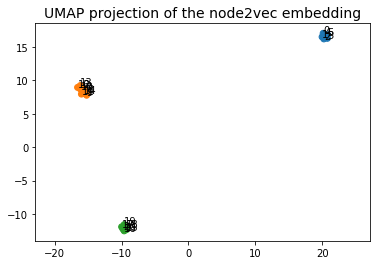

In [6]:
reducer = umap.UMAP(n_neighbors=8, metric = 'cosine', n_components=2)
u_emb = reducer.fit_transform(node2vec_ebds)
plt.scatter(u_emb[:, 0], u_emb[:, 1], c=[sns.color_palette()[x] for x in target])
#plt.scatter(u_emb[:, 0], u_emb[:, 1], c=target, cmap='Spectral', s=25)
#plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))
for i, txt in enumerate(nodes):
    plt.annotate(txt, (u_emb[i, 0], u_emb[i, 1]))
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the node2vec embedding', fontsize=14);

## Perfect!!!

### Topological embedding

In [7]:
filepath = "ints_21_0.3_0.4_0.3_2_2.txt"
embd = TDAembedding(filepath, num_nodes=wAdj.shape[0])

In [8]:
intervals = embd.read_intervals(h0=True, h1=True)
df0 = embd.create_h0_embedding(intervals=intervals)
df1 = embd.create_h1_embedding(intervals=intervals)

In [9]:
df0.head()

,0.054,0.064,0.084,0.086,0.127,0.152,0.186,0.189,0.194,0.213,0.216,0.218,0.224,0.255,0.262,0.264,0.271,0.288,0.504
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,6,20
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,6,20
2,1,1,1,1,1,1,1,1,1,1,2,3,3,3,3,3,4,6,20
3,1,1,1,1,1,1,1,1,1,1,2,3,3,3,3,3,4,6,20
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,6,20


In [12]:
df1.head()

,0.22-0.31,0.24-0.43,0.25-0.34,0.25-0.31,0.26-0.38,0.29-0.34,0.34-0.34,0.52-0.76,0.52-0.80,0.53-0.85,0.58-0.83,0.65-0.72,0.76-0.76,0.77-0.89,0.80-0.83,0.80-0.84,0.81-0.85,num_ints,mean_int
0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,2,0.014941
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.014529
2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,3,0.021353
3,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,5,0.042529
4,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,4,0.023294


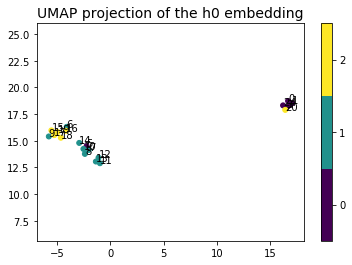

In [10]:
reducer = umap.UMAP(n_neighbors=7, metric = 'cosine', n_components=2)
u_emb0 = reducer.fit_transform(df0.values)
#plt.scatter(u_emb[:, 0], u_emb[:, 1], c=[sns.color_palette()[x] for x in target])
plt.scatter(u_emb0[:, 0], u_emb0[:, 1], c=target, cmap='viridis', s=25)
plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))
for i, txt in enumerate(nodes):
    plt.annotate(txt, (u_emb0[i, 0], u_emb0[i, 1]))
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the h0 embedding', fontsize=14);

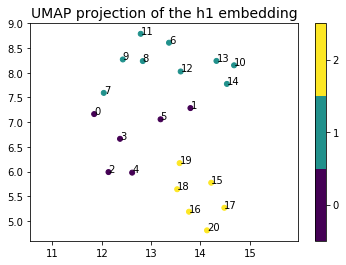

In [11]:
reducer = umap.UMAP(n_neighbors=7, metric = 'cosine', n_components=2)
u_emb1 = reducer.fit_transform(df1.values[:,:-2])
#u_emb1 = reducer.fit_transform(df1.drop('num_ints', axis=1).values)
#plt.scatter(u_emb[:, 0], u_emb[:, 1], c=[sns.color_palette()[x] for x in target])
plt.scatter(u_emb1[:,0], u_emb1[:, 1], c=target, cmap='viridis', s=25)
plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))
plt.gca().set_aspect('equal', 'datalim')
for i, txt in enumerate(nodes):
    plt.annotate(txt, (u_emb1[i, 0], u_emb1[i, 1]))
plt.title('UMAP projection of the h1 embedding', fontsize=14);

## Not so good, but still interpretable

## Weak blocks

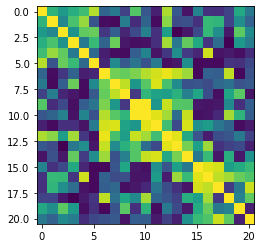

In [14]:
fname = "wAdj_0.3_0.4_0.3_1_1.mat"
with h5py.File(fname,'r') as f:
    wAdj = np.array(f[list(f.keys())[0]])
pi_vector = [float(str.split(fname,'_')[el]) for el in range(1,4)]  
target = generate_clusters(wAdj.shape[0], pi_vector).astype('int')
plt.imshow(wAdj)

In [15]:
graph = nx.from_numpy_matrix(wAdj)
node2vec = Node2Vec(graph, dimensions=25, walk_length=15, p=0.5,q=1, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
nodes = [str(node) for node in range(wAdj.shape[0])]
vecs = []
for node in nodes:
    vecs.append(model.wv.__getitem__([node]))
node2vec_ebds = np.squeeze(np.array(vecs))    

Computing transition probabilities: 100%|██████████| 21/21 [00:00<00:00, 626.19it/s]


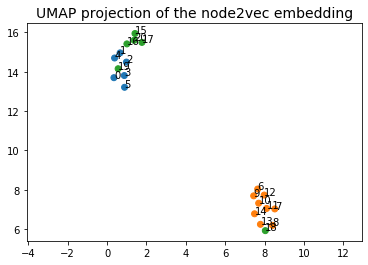

In [21]:
reducer = umap.UMAP(n_neighbors=8, metric = 'cosine', n_components=2)
u_emb = reducer.fit_transform(node2vec_ebds)
plt.scatter(u_emb[:, 0], u_emb[:, 1], c=[sns.color_palette()[x] for x in target])
#plt.scatter(u_emb[:, 0], u_emb[:, 1], c=target, cmap='Spectral', s=25)
#plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))
for i, txt in enumerate(nodes):
    plt.annotate(txt, (u_emb[i, 0], u_emb[i, 1]))
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the node2vec embedding', fontsize=14);

## Not so good and hard to explain 

In [17]:
filepath = "ints_21_0.3_0.4_0.3_2_2.txt"
embd = TDAembedding(filepath, num_nodes=wAdj.shape[0])
intervals = embd.read_intervals(h0=True, h1=True)
df0 = embd.create_h0_embedding(intervals=intervals)
df1 = embd.create_h1_embedding(intervals=intervals)

In [18]:
df0.head()

,0.054,0.064,0.084,0.086,0.127,0.152,0.186,0.189,0.194,0.213,0.216,0.218,0.224,0.255,0.262,0.264,0.271,0.288,0.504
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,6,20
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,6,20
2,1,1,1,1,1,1,1,1,1,1,2,3,3,3,3,3,4,6,20
3,1,1,1,1,1,1,1,1,1,1,2,3,3,3,3,3,4,6,20
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,6,20


In [19]:
df1.head()

,0.22-0.31,0.24-0.43,0.25-0.34,0.25-0.31,0.26-0.38,0.29-0.34,0.34-0.34,0.52-0.76,0.52-0.80,0.53-0.85,0.58-0.83,0.65-0.72,0.76-0.76,0.77-0.89,0.80-0.83,0.80-0.84,0.81-0.85,num_ints,mean_int
0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,2,0.014941
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.014529
2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,3,0.021353
3,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,5,0.042529
4,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,4,0.023294


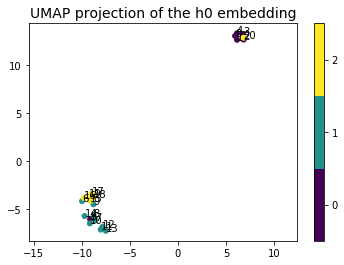

In [20]:
reducer = umap.UMAP(n_neighbors=7, metric = 'cosine', n_components=2)
u_emb0 = reducer.fit_transform(df0.values)
#plt.scatter(u_emb[:, 0], u_emb[:, 1], c=[sns.color_palette()[x] for x in target])
plt.scatter(u_emb0[:, 0], u_emb0[:, 1], c=target, cmap='viridis', s=25)
plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))
for i, txt in enumerate(nodes):
    plt.annotate(txt, (u_emb0[i, 0], u_emb0[i, 1]))
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the h0 embedding', fontsize=14);

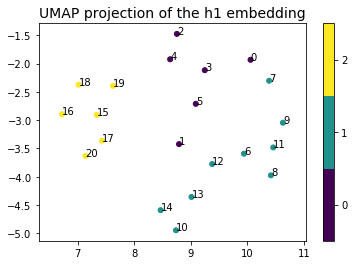

In [22]:
reducer = umap.UMAP(n_neighbors=7, metric = 'cosine', n_components=2)
u_emb1 = reducer.fit_transform(df1.values[:,:-2])
plt.scatter(u_emb1[:,0], u_emb1[:, 1], c=target, cmap='viridis', s=25)
plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))
plt.gca().set_aspect('equal', 'datalim')
for i, txt in enumerate(nodes):
    plt.annotate(txt, (u_emb1[i, 0], u_emb1[i, 1]))
plt.title('UMAP projection of the h1 embedding', fontsize=14);

## much better??